In [64]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.metrics import roc_curve,auc
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
import time
from sklearn.ensemble import VotingClassifier

In [67]:
def clean(data):
    data["Age"] = data["Age"].fillna(data["Age"].mean())
    data["Embarked"] = data["Embarked"].fillna("S")
    data.dropna(subset = ["Cabin"])
    data.loc[data["Sex"] == "male", "Sex"] = 0
    data.loc[data["Sex"] == "female", "Sex"] = 1
    data.loc[data["Embarked"] == "S", "Embarked"] = 0
    data.loc[data["Embarked"] == "C", "Embarked"] = 1
    data.loc[data["Embarked"] == "Q", "Embarked"] = 2
    return data

In [107]:
def clean2(data):
    #groupby by sex and get <age> for NA's
    data["Age"].fillna(data.groupby("Sex")["Age"].transform("mean"), inplace=True)
    
    #remove NA columns for missing Embarked
    data = data.dropna(subset = ["Embarked"])
    data = data.dropna(subset = ["Fare"])
    
    data["Embarked"] = data["Embarked"].fillna("S")
    data.dropna(subset = ["Cabin"])
    
    data=data.drop(data[data.Fare > 300].index)
    data=data.drop(data[data.Fare <1].index)
    data.loc[data["Sex"] == "male", "Sex"] = 0
    data.loc[data["Sex"] == "female", "Sex"] = 1
    data.loc[data["Embarked"] == "S", "Embarked"] = 0
    data.loc[data["Embarked"] == "C", "Embarked"] = 1
    data.loc[data["Embarked"] == "Q", "Embarked"] = 2
    return data

In [69]:
# get titanic & test csv files as a DataFrame
data = pd.read_csv("./train.csv", dtype={"Age": np.float64}, )
data = clean2(data)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
#data.head()
print data.isnull().sum()
print data.shape

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          674
Embarked         0
dtype: int64
(871, 12)


In [71]:
#predictors = ["Pclass","Sex","Age","Embarked","SibSp"]
predictors = ["Pclass","Sex","Age","Embarked","SibSp","Parch","Fare"]
X = data[predictors]
y = data['Survived']
print X.shape
print y.shape

(871, 7)
(871,)


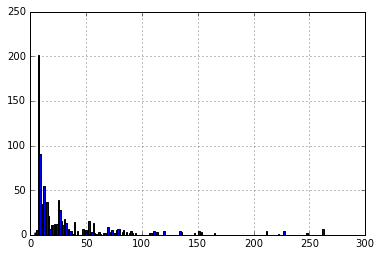

In [72]:
X['Fare'].hist(bins=200)

In [22]:
clf1 = KNeighborsClassifier()
clf2 = LogisticRegression()
clf3 = RandomForestClassifier()
eclf = VotingClassifier(estimators=[('knn', clf1), ('lg', clf2),
                                    ('RF', clf3)],voting='soft', weights=[1, 1, 1])

score_knn = cross_val_score(clf1, X, y, cv=10, scoring='accuracy')
score_lg = cross_val_score(clf2, X, y, cv=10, scoring='accuracy')
score_rf = cross_val_score(clf3, X, y, cv=10, scoring='accuracy')
score_vot = cross_val_score(eclf, X, y, cv=10, scoring='accuracy')

#print clf1
#print clf2
#print clf3
#print eclf

print score_knn.mean()
print score_lg.mean()
print score_rf.mean()
print score_vot.mean()

0.702790829645
0.793540744524
0.799272500284
0.80933463852


In [87]:
def prepareSubmission():
    eclf.fit(X,y)
    test_df = pd.read_csv("./test.csv", dtype={"Age": np.float64}, )
    test_df = clean2(test_df)
    ytest = test_df[predictors]
    predicted = eclf.predict(ytest)
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predicted
    })
    submission.to_csv("result_vote_20160712.csv", index=False)

In [90]:
#prepareSubmission()

In [108]:
test_df = pd.read_csv("./test.csv", dtype={"Age": np.float64}, )

In [109]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [110]:
test_df = clean2(test_df)

In [111]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0


In [112]:
ytest = test_df[predictors]

In [113]:
ytest.head()

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
0,3,0,34.5,2,0,0,7.8292
1,3,1,47.0,0,1,0,7.0000
2,2,0,62.0,2,0,0,9.6875
3,3,0,27.0,0,0,0,8.6625
4,3,1,22.0,0,1,1,12.2875


In [114]:
ytest.isnull().sum()

Pclass      0
Sex         0
Age         0
Embarked    0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [115]:
predicted = eclf.predict(ytest)

In [116]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predicted
    })
submission.to_csv("result_vote_20160712.csv", index=False)

In [117]:
#LogRegression
param_range = [0.0001, 0.001, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0250, 0.05, 0.1, 1,2 ,5 ,10, 15, 20, 50 , 100]
penalty_range = ['l1','l2']
param_grid = [{'clf__C':param_range,
              'clf__penalty':penalty_range}]

#RF
estimator_range = range(1,50)
criter = ['gini','entropy']
depth_range = range(1,10)
param_grid_rf = [{'clf__n_estimators':estimator_range,
               'clf__criterion':criter,
               'clf__max_depth':depth_range}]

#KNN grid parameters
neighbors = range(1,100)
weights = ['uniform','distance']
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
distance = ['euclidean','manhattan','minkowski']
param_grid_knn = [{'clf__n_neighbors':neighbors,
                   'clf__algorithm':algo,
                   'clf__metric':distance,
                   'clf__weights':weights}]

In [118]:
#LogRegression
pipe_lg_g = Pipeline([('scl',StandardScaler()),
                      ('clf',LogisticRegression())])
#RF
pipe_rf_g = Pipeline([('scl',StandardScaler()),
                      ('clf',RandomForestClassifier())])
#KNN
pipe_knn_g = Pipeline([('scl',StandardScaler()),
                      ('clf',KNeighborsClassifier())])

In [119]:
#KNN
gs = GridSearchCV(estimator=pipe_knn_g,
                 param_grid = param_grid_knn,
                 scoring='accuracy',
                 cv=10)
gs = gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)

{'clf__metric': 'manhattan', 'clf__weights': 'uniform', 'clf__algorithm': 'brute', 'clf__n_neighbors': 15}
0.822043628014


In [120]:
#LogRegression
gs2 = GridSearchCV(estimator=pipe_lg_g,
                 param_grid = param_grid,
                 scoring='accuracy',
                 cv=10)
gs2 = gs2.fit(X,y)
print(gs2.best_params_)
print(gs2.best_score_)

{'clf__penalty': 'l2', 'clf__C': 5}
0.793340987371


In [121]:
#RF
gs3 = GridSearchCV(estimator=pipe_rf_g,
                 param_grid = param_grid_rf,
                 scoring='accuracy',
                 cv=10)
gs3 = gs3.fit(X,y)
print(gs3.best_params_)
print(gs3.best_score_)

{'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__n_estimators': 13}
0.843857634902


In [122]:
c1 = KNeighborsClassifier(metric='manhattan',weights='uniform',algorithm='brute',n_neighbors=15)
c2 = LogisticRegression(penalty='l1',C=5)
c3 = RandomForestClassifier(criterion='entropy',max_depth=8,n_estimators=13)
vf = VotingClassifier(estimators=[('knn', c1), ('lg', c2),
                                  ('RF', c3)],voting='soft', weights=[1, 1, 1])

In [123]:
c1.fit(X,y)
c2.fit(X,y)
c3.fit(X,y)
vf.fit(X,y)
print c1.score(X,y)
print c2.score(X,y)
print c3.score(X,y)
print vf.score(X,y)

0.756601607348
0.794489092997
0.904707233065
0.870264064294


In [124]:
test_df = pd.read_csv("./test.csv", dtype={"Age": np.float64}, )
test_df = clean2(test_df)
ytest = test_df[predictors]
predicted = vf.predict(ytest)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predicted
    })
submission.to_csv("result_vote_20160712.csv", index=False)

In [142]:
X_train, X_test, y_train,y_test = train_test_split(X,y)

In [143]:
c1.fit(X_train,y_train)
c2.fit(X_train,y_train)
c3.fit(X_train,y_train)
vf.fit(X_train,y_train)
print c1.score(X_train,y_train)
print c2.score(X_train,y_train)
print c3.score(X_train,y_train)
print vf.score(X_train,y_train)

0.756508422665
0.817764165391
0.923430321593
0.874425727412


In [144]:
prediction_knn = c1.predict_proba(X_test)
y_pred_knn = prediction_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn,tpr_knn)

In [145]:
prediction_lg = c2.predict_proba(X_test)
y_pred_lg = prediction_lg[:,1]
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_lg)
roc_auc_lg = auc(fpr_lg,tpr_lg)

In [146]:
prediction_rf = c3.predict_proba(X_test)
y_pred_rf = prediction_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

In [147]:
prediction_vote = vf.predict_proba(X_test)
y_pred_vote = prediction_vote[:,1]
fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_pred_vote)
roc_auc_vote = auc(fpr_vote,tpr_vote)

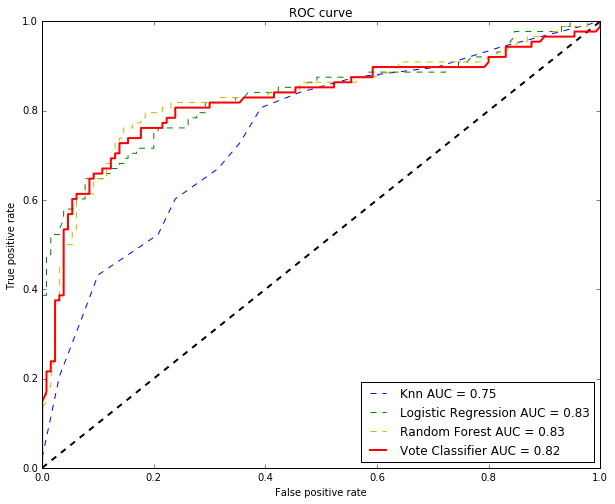

In [148]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--',linewidth=2)
plt.plot(fpr_knn, tpr_knn, 'b',linestyle='--',label = 'Knn AUC = %0.2f' % roc_auc_knn)
plt.plot(fpr_lg, tpr_lg, 'g',linestyle='--',label = 'Logistic Regression AUC = %0.2f' % roc_auc_lg)
plt.plot(fpr_rf, tpr_rf, 'y',linestyle='--',label = 'Random Forest AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_vote, tpr_vote, 'r',linewidth=2,label = 'Vote Classifier AUC = %0.2f' % roc_auc_vote)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()